- try to fill missing values
- apply auto-correlation 
- check the model feature importances
- use the `user activity`
- apply aggregations for the warehouse 
- apply moving average 
- Clip the taget

In [368]:
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import random
from math import pi
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
from statsmodels.tsa.seasonal import seasonal_decompose
class CFG:
    data_folder = '/Users/ahmed/Downloads/computerscience/AI-Compeitions/Rohlik Orders Forecasting Challenge/Data/'
    img_dim1 = 20
    img_dim2 = 10
    img_dim1 = 20
    img_dim2 = 10

#setting the metrics:

In [369]:
#reduce memory usage 
def reduce_memory_usage(df, categ = True):
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                if categ:
                    df[col] = df[col].astype('category')
    
    return df

def get_cat_num_feats(df: pd.DataFrame) -> list:
    cat_feats = df.select_dtypes(include=['object','O', 'category'])
    num_feats = df.select_dtypes(include=['int','int8','int16','int16','int32','int64','float16','float32'])
    time_feats = df.select_dtypes(include=['datetime64[ns]'])
    binary_feats = []
    
    for col in df.columns:
        if df[col].nunique() == 2:
            binary_feats.append(col)

    return cat_feats.columns,num_feats.columns, time_feats.columns, binary_feats

In [370]:
def reading_data(path:str):
    smaple = pd.read_csv(path+'solution_example.csv')
    train = pd.read_csv(path + "train.csv")
    test = pd.read_csv(path + "test.csv")
    test_id = test['id']  # store the 'id' column from the test dataframe
    return train, test, test_id

train, test, test_ids = reading_data(CFG.data_folder)
#train = reduce_memory_usage(df = train,categ = True)
#test = reduce_memory_usage(df = train,categ = True)
train_date = train['date']
test_date = test['date']

In [371]:
def get_time_features(train: pd.DataFrame, test: pd.DataFrame) -> pd.DataFrame:      
    for df in (train, test):
        df['date'] = pd.to_datetime(df['date'])
        df['date_day'] = df['date'].dt.day
        df['week'] = df['date'].dt.dayofweek
        df['date_month'] = df['date'].dt.month
        df['Year'] = df['date'].dt.year
        df['friday'] = (df['date'].dt.dayofweek == 4).astype(int) 
        #df['sunday'] = (df['date'].dt.dayofweek == 6).astype(int) 
        #df['the_fun_2'] = df['sunday'] + df['friday']
        df['holiday_before'] = df['holiday'].shift(1).fillna(0).astype(int)
        df['holiday_after'] = df['holiday'].shift(-1).fillna(0).astype(int)
        df.drop(columns=['date','id'], inplace=True)
    return train, test

train, test = get_time_features(train=train, test=test)


In [372]:
"""
import numpy as np
import pandas as pd

def get_time_features(train: pd.DataFrame, test: pd.DataFrame) -> pd.DataFrame:      
    for df in (train, test):
        df['date'] = pd.to_datetime(df['date'])
        df['date_day'] = df['date'].dt.day
        df['week'] = df['date'].dt.dayofweek
        df['date_month'] = df['date'].dt.month
        df['Year'] = df['date'].dt.year
        df['hour'] = df['date'].dt.hour
        
        # Cyclic encoding for time features

        df['friday'] = (df['date'].dt.dayofweek == 4).astype(int) 
        df['holiday_before'] = df['holiday'].shift(1).fillna(0).astype(int)
        df['holiday_after'] = df['holiday'].shift(-1).fillna(0).astype(int)
        df['holiday_after3'] = df['holiday'].shift(3).fillna(0).astype(int)
        df['day_after3'] = df['date_day'].shift(3).fillna(0).astype(int)
        
        # Rolling features to capture trends (Only for train data)
        if 'orders' in df.columns:
            df['orders_7d_avg'] = df['orders'].shift(1).rolling(window=7).mean()
            df['orders_7d_std'] = df['orders'].shift(1).rolling(window=7).std()
            df['orders_14d_avg'] = df['orders'].shift(1).rolling(window=14).mean()
            df['orders_14d_std'] = df['orders'].shift(1).rolling(window=14).std()
        
            # Lagged features to capture autocorrelation
            df['orders_lag1'] = df['orders'].shift(1)
            df['orders_lag7'] = df['orders'].shift(7)
            df['orders_lag14'] = df['orders'].shift(14)
        
        df.drop(columns=['date','id'], inplace=True)
        
    return train, test

# Training phase
train, test = get_time_features(train=train, test=test)

# Prediction phase
def predict_with_lagged_features(model, train: pd.DataFrame, test: pd.DataFrame) -> np.array:
    predictions = []
    test_copy = test.copy()
    
    for i in range(len(test_copy)):
        if i == 0:
            # For the first prediction, use only available test features
            features = test_copy.iloc[i:i+1]
        else:
            # Update the lagged features with the previous predictions
            test_copy.loc[i, 'orders_lag1'] = predictions[-1]
            if i >= 7:
                test_copy.loc[i, 'orders_lag7'] = predictions[-7]
            if i >= 14:
                test_copy.loc[i, 'orders_lag14'] = predictions[-14]
                
            features = test_copy.iloc[i:i+1]
        
        pred = model.predict(features)  # Assuming model.predict() returns an array
        predictions.append(pred[0])
    
    return np.array(predictions)

# Example model usage (Replace with actual model)
# from some_ml_library import SomeModel
# model = SomeModel()
# model.fit(train.drop('orders', axis=1), train['orders'])
# test_predictions = predict_with_lagged_features(model, train, test)
"""

"\nimport numpy as np\nimport pandas as pd\n\ndef get_time_features(train: pd.DataFrame, test: pd.DataFrame) -> pd.DataFrame:      \n    for df in (train, test):\n        df['date'] = pd.to_datetime(df['date'])\n        df['date_day'] = df['date'].dt.day\n        df['week'] = df['date'].dt.dayofweek\n        df['date_month'] = df['date'].dt.month\n        df['Year'] = df['date'].dt.year\n        df['hour'] = df['date'].dt.hour\n        \n        # Cyclic encoding for time features\n\n        df['friday'] = (df['date'].dt.dayofweek == 4).astype(int) \n        df['holiday_before'] = df['holiday'].shift(1).fillna(0).astype(int)\n        df['holiday_after'] = df['holiday'].shift(-1).fillna(0).astype(int)\n        df['holiday_after3'] = df['holiday'].shift(3).fillna(0).astype(int)\n        df['day_after3'] = df['date_day'].shift(3).fillna(0).astype(int)\n        \n        # Rolling features to capture trends (Only for train data)\n        if 'orders' in df.columns:\n            df['orders_7

# Feature Engineering - Time Series

# Encoding

In [373]:
def encoding(train: pd.DataFrame, test: pd.DataFrame) -> pd.DataFrame:
    train = pd.get_dummies(train, columns=['holiday_name'], drop_first=True)
    test = pd.get_dummies(test, columns=['holiday_name'], drop_first=True)

    encoder = LabelEncoder()
    cat_feats = train.select_dtypes(include='object')
    for df in (train, test):
        for col in df.columns:
            if col in cat_feats and col != 'holiday_name':
                df[col] = encoder.fit_transform(df[col])

    return train, test

train, test = encoding(train, test)


# Building the CV

In [374]:
for col in train.columns:
    if col not in test.columns:
        if col != 'orders':
            train.drop(columns=col,axis=1, inplace=True)

In [376]:
model = LGBMRegressor(random_state = 777)
groups = train['warehouse']
n_splits = 5 
tscv = TimeSeriesSplit(n_splits=n_splits)

def validate(trainset, testset, target_col):
    model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    print('std:', valid_testset.std())
    score = mean_absolute_percentage_error(valid_testset, valid_pred)
    print('score :',score)
    return score
stds = []
mapes = []

for train_index , test_index in tscv.split(train.drop(columns=['orders']), train['orders'], groups=groups): 
    train_v, test_v = train.iloc[train_index], train.iloc[test_index]
    stds.append(test_v['orders'])
    mapes.append(validate(train_v,test_v,'orders'))
print('mape :' ,np.array(mapes).mean())
print('mapes stds :', np.array(mapes).std())
print('stds :', stds)
print('mapes :', mapes)

/Users/ahmed/Downloads/computerscience/AI-Compeitions/Rohlik Orders Forecasting Challenge/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/model_selection/_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 1225, number of used features: 13
[LightGBM] [Info] Start training from score 8476.468571
std: 1129.7141856748206
score : 0.16722844406679394
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 2448, number of used features: 13
[LightGBM] [Info] Start training

In [377]:
train

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,date_day,week,date_month,Year,friday,sunday,the_fun_2,holiday_before,holiday_after,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Labour Day,holiday_name_Memorial Day for the Victims of the Holocaust
0,4,6895.0,0,0,0,0,5,5,12,2020,0,0,0,0,0,False,False,False,False
1,4,6584.0,0,0,0,0,6,6,12,2020,0,1,1,0,0,False,False,False,False
2,4,7030.0,0,0,0,0,7,0,12,2020,0,0,0,0,0,False,False,False,False
3,4,6550.0,0,0,0,0,8,1,12,2020,0,0,0,0,0,False,False,False,False
4,4,6910.0,0,0,0,0,9,2,12,2020,0,0,0,0,0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7335,1,6733.0,0,0,0,0,10,6,3,2024,0,1,1,0,0,False,False,False,False
7336,1,6492.0,0,0,0,0,11,0,3,2024,0,0,0,0,0,False,False,False,False
7337,1,6661.0,0,0,0,0,12,1,3,2024,0,0,0,0,0,False,False,False,False
7338,1,6843.0,0,0,0,0,13,2,3,2024,0,0,0,0,0,False,False,False,False


In [378]:
for df in (train,test):
    for col in ['holiday_name_Memorial Day for the Victims of the Holocaust',
        'holiday_name_Labour Day', 'sunday', 'holiday_name_Easter Monday',
        'holiday_name_Good Friday']:
        df.drop(columns=[col], inplace=True)

In [379]:
train

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,date_day,week,date_month,Year,friday,the_fun_2,holiday_before,holiday_after
0,4,6895.0,0,0,0,0,5,5,12,2020,0,0,0,0
1,4,6584.0,0,0,0,0,6,6,12,2020,0,1,0,0
2,4,7030.0,0,0,0,0,7,0,12,2020,0,0,0,0
3,4,6550.0,0,0,0,0,8,1,12,2020,0,0,0,0
4,4,6910.0,0,0,0,0,9,2,12,2020,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7335,1,6733.0,0,0,0,0,10,6,3,2024,0,1,0,0
7336,1,6492.0,0,0,0,0,11,0,3,2024,0,0,0,0
7337,1,6661.0,0,0,0,0,12,1,3,2024,0,0,0,0
7338,1,6843.0,0,0,0,0,13,2,3,2024,0,0,0,0


In [380]:
#0.4578672537754837 in leaderboard 0.0774
#0.4568272951153025 in leaderboard 0.0685
#0.4492822482665694 in leaderboard 0.0453

In [381]:
model.fit(train.drop(columns='orders'),train['orders'])
y_predict = model.predict(test)
sub_df = pd.DataFrame({'id': test_ids,'orders':y_predict})
sub_df.to_csv('/Users/ahmed/Downloads/computerscience/AI-Compeitions/Rohlik Orders Forecasting Challenge/submiession/submission04482807340255196.csv', index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 7340, number of used features: 13
[LightGBM] [Info] Start training from score 5535.443869


In [382]:
train_cols = set(train.columns)
test_cols = set(test.columns)
diff = train_cols.symmetric_difference(test_cols)

print("\nDifference between columns:")
print(diff)


Difference between columns:
{'orders'}


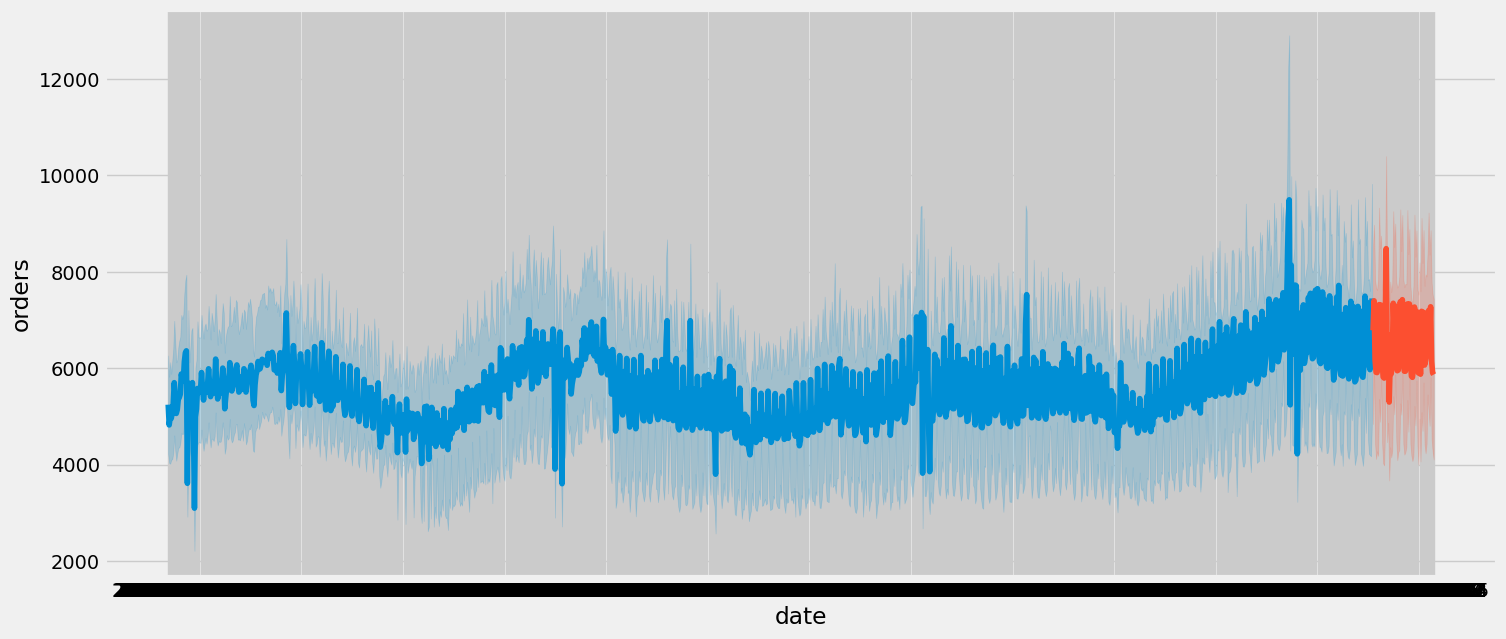

In [383]:
plt.figure(figsize=(16 , 7))
sns.lineplot(x=train_date, y=train.orders)
sns.lineplot(x=test_date, y= y_predict)
plt.show()

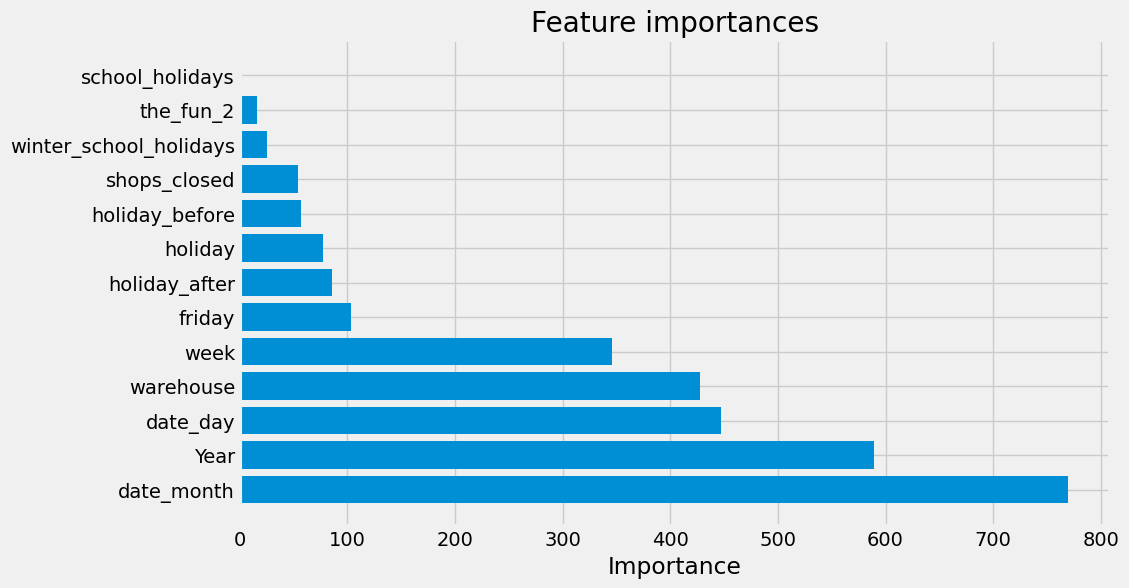

In [384]:
importances = model.feature_importances_

feature_names = train.drop(columns='orders').columns
indices = np.argsort(importances)[::-1]

feature_names = feature_names[indices]
importances = importances[indices]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.barh(range(len(feature_names)), importances, align="center")
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel("Importance")
plt.show()

In [385]:
feature_names

Index(['date_month', 'Year', 'date_day', 'warehouse', 'week', 'friday',
       'holiday_after', 'holiday', 'holiday_before', 'shops_closed',
       'winter_school_holidays', 'the_fun_2', 'school_holidays'],
      dtype='object')

In [386]:
importances

array([770, 589, 447, 428, 346, 103,  86,  77,  57,  54,  25,  16,   2],
      dtype=int32)

In [387]:
train.columns

Index(['warehouse', 'orders', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'date_day', 'week',
       'date_month', 'Year', 'friday', 'the_fun_2', 'holiday_before',
       'holiday_after'],
      dtype='object')

#check the dates of the test and the train 
#the publich leaderboard is not 30% first of the data and not the last 30% of the data. 
#read the book and finish the course 
#try the same methods here in the foreast one you build.